XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.
Test generalization by training and testing on different stations

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190728-093938'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
landcover, landcover_legend = load_data.load_landcover_reduced()

../src/load_data.py:242: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  landcover_fullres = np.array(landcover_nc['Band1'][:])[::-1,:]


In [4]:
station_cell_mapping = load_data.get_station_cell_mapping()

In [5]:
for station in station_data_dict.keys():
    for i in range(len(landcover_legend)):
        for row_col in station_cell_mapping[station_cell_mapping['station'] == station][['row','col']].values:
            cell_id = 39 * (row_col[1] - 1) + (row_col[0] - 1)
            station_data_dict[station]['{}_{}'.format(landcover_legend[i], cell_id)] = landcover[i,row_col[1]-1,row_col[0]-1]

In [6]:
test_station_fraction = 0.25
num_test_stations = int(len(station_data_dict.keys()) * test_station_fraction)
test_stations = np.random.choice(list(station_data_dict.keys()), size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if s not in test_stations))
train_stations, test_stations

(array(['02GA010', '02GA018', '02GA038', '02GA047', '02GB007', '02GC002',
        '02GC007', '02GC010', '02GC018', '02GE007', '02GG002', '02GG003',
        '02GG006', '02GG009', '02GG013', '04159492', '04159900',
        '04161820', '04165500', '04166100', '04174500', '04176500',
        '04198000', '04199000', '04199500', '04200500', '04207200',
        '04208504', '04209000', '04212100', '04213000', '04213500',
        '04214500', '04215000', '04215500'], dtype='<U8'),
 array(['04166500', '04164000', '04177000', '02GB001', '02GC026',
        '04196800', '04193500', '02GD004', '04160600', '04197100',
        '04195820'], dtype='<U8'))

In [7]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(train_stations))].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()
    
test = data[(data['date'] >= test_start) & (data['date'] <= test_end) & (data['station'].isin(test_stations))].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

m = xgb.XGBRegressor(n_estimators=1000, n_jobs=40, random_state=123, colsample_bylevel=0.6729787471081543, colsample_bytree=0.45664887689862715,
                     gamma=0.8647323574990862, learning_rate=0.046906503071064753, max_depth=5, min_child_weight=11, reg_alpha=3.815080535669582, 
                     reg_lambda=15.085572859138352, subsample=0.8186204494424377)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=True)

test = test[~pd.isna(test['runoff'])]

predict = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
predict['is_test_station'] = predict['station'].apply(lambda s: s in test_stations)
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'is_test_station'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Shapes: train (33309, 15624), val (3701, 15624), test (8030, 15624)


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:28.2255	validation_1-rmse:25.6197
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:27.7743	validation_1-rmse:25.2509
[2]	validation_0-rmse:27.3247	validation_1-rmse:24.8952
[3]	validation_0-rmse:26.9162	validation_1-rmse:24.573
[4]	validation_0-rmse:26.534	validation_1-rmse:24.2816
[5]	validation_0-rmse:26.1558	validation_1-rmse:24.0138
[6]	validation_0-rmse:25.7992	validation_1-rmse:23.753
[7]	validation_0-rmse:25.4547	validation_1-rmse:23.5087
[8]	validation_0-rmse:25.1354	validation_1-rmse:23.3092
[9]	validation_0-rmse:24.8342	validation_1-rmse:23.1137
[10]	validation_0-rmse:24.5527	validation_1-rmse:22.9161
[11]	validation_0-rmse:24.2647	validation_1-rmse:22.7376
[12]	validation_0-rmse:23.991	validation_1-rmse:22.5606
[13]	validation_0-rmse:23.7323	validation_1-rmse:22.3912
[14]	validation_0-rmse:23.4782	validation_1-rmse:22.2366

02GA010 	NSE: 0.2699370034784442 	MSE: 348.0747253114433 (clipped to 0)
02GA018 	NSE: 0.2539849051869716 	MSE: 187.36406376482142 (clipped to 0)
02GA038 	NSE: 0.20803051695495456 	MSE: 130.30943667505255 (clipped to 0)
02GA047 	NSE: -0.016951650725600897 	MSE: 79.7188649831432 (clipped to 0)
02GB001 	NSE: -0.6088785428172552 	MSE: 12082.477066267027 (clipped to 0)
02GB007 	NSE: 0.23163233520575832 	MSE: 24.02840477684589 (clipped to 0)
02GC002 	NSE: 0.4224124857730055 	MSE: 74.22174833707611 (clipped to 0)
02GC007 	NSE: 0.1185963120625122 	MSE: 26.549064104852533 (clipped to 0)
02GC010 	NSE: 0.2699403823106121 	MSE: 43.401985720026325 (clipped to 0)
02GC018 	NSE: 0.47369738209741286 	MSE: 35.64479304956465 (clipped to 0)
02GC026 	NSE: -0.02898134363730498 	MSE: 165.49390263432693 (clipped to 0)
02GD004 	NSE: 0.010368825861668318 	MSE: 54.4921339933428 (clipped to 0)
02GE007 	NSE: 0.09552442259143457 	MSE: 32.71945690615062 (clipped to 0)
02GG002 	NSE: 0.5947593047361881 	MSE: 97.737096

../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04164000 	NSE: 0.3284024846949999 	MSE: 117.68225801220093 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04165500 	NSE: 0.5380167128560808 	MSE: 206.81093844461674 (clipped to 0)
04166100 	NSE: -0.33726755535127095 	MSE: 9.80659444205957 (clipped to 0)
04166500 	NSE: 0.10527746291679929 	MSE: 30.925451350750357 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04174500 	NSE: 0.34045814006966646 	MSE: 62.37566789929133 (clipped to 0)
04176500 	NSE: 0.216788055381958 	MSE: 534.9918853240647 (clipped to 0)
04177000 	NSE: -0.0393441156685419 	MSE: 28.010147032380555 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04193500 	NSE: -0.22875534550738497 	MSE: 86996.79912878285 (clipped to 0)
04195820 	NSE: -0.1878639513216418 	MSE: 1394.3079771299706 (clipped to 0)
04196800 	NSE: -0.727552259069774 	MSE: 516.9673997021029 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04197100 	NSE: -5.426494495388141 	MSE: 659.1296146383785 (clipped to 0)
04198000 	NSE: 0.5405059272943876 	MSE: 3394.5397569496185 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04199000 	NSE: 0.4779111223337088 	MSE: 533.8898090830328 (clipped to 0)
04199500 	NSE: 0.39175772971823586 	MSE: 246.1240923662776 (clipped to 0)
04200500 	NSE: 0.5421691964515934 	MSE: 458.1535540781092 (clipped to 0)
04207200 	NSE: 0.1360057074611153 	MSE: 20.222902088149244 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04208504 	NSE: 0.5448814207693347 	MSE: 444.4363345755607 (clipped to 0)
04209000 	NSE: 0.49881802527692565 	MSE: 156.69755950741984 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04212100 	NSE: 0.5538982192476034 	MSE: 655.0224138740409 (clipped to 0)
04213000 	NSE: 0.41129661810370344 	MSE: 105.65414640509367 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04213500 	NSE: 0.5248524728105209 	MSE: 486.74912996064745 (clipped to 0)
04214500 	NSE: 0.364394077282569 	MSE: 76.61408643927471 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215000 	NSE: 0.22448117592618055 	MSE: 74.49076444700283 (clipped to 0)
04215500 	NSE: 0.4035577141774015 	MSE: 107.70847742801506 (clipped to 0)
Train Median NSE (clipped to 0) 0.39175772971823586 / Min -0.33726755535127095 / Max 0.607843588496287
Train Median MSE (clipped to 0) 97.7370962672103 / Min 9.80659444205957 / Max 3394.5397569496185
Test Median NSE (clipped to 0) -0.11977091677389051 / Min -5.426494495388141 / Max 0.3284024846949999
Test Median MSE (clipped to 0) 165.49390263432693 / Min 28.010147032380555 / Max 86996.79912878285


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


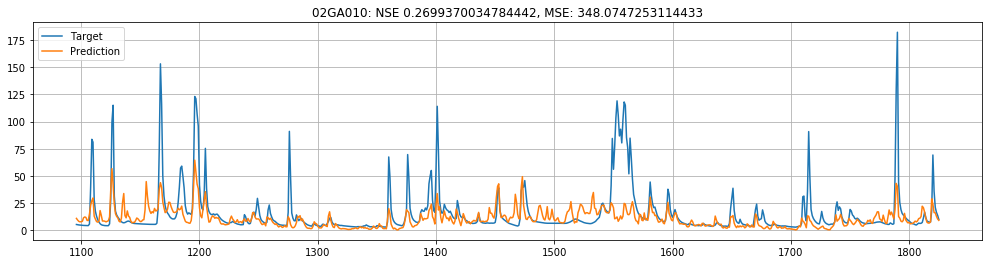

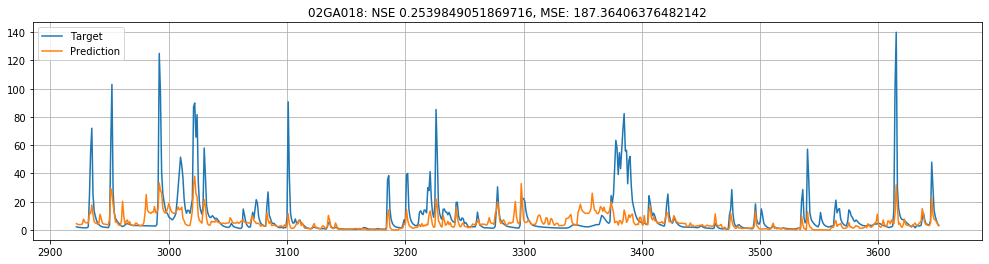

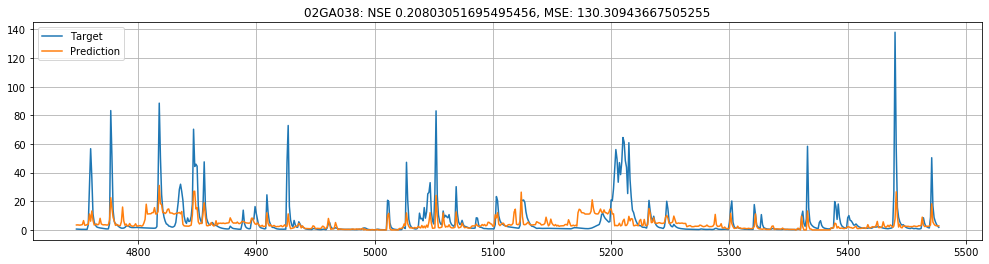

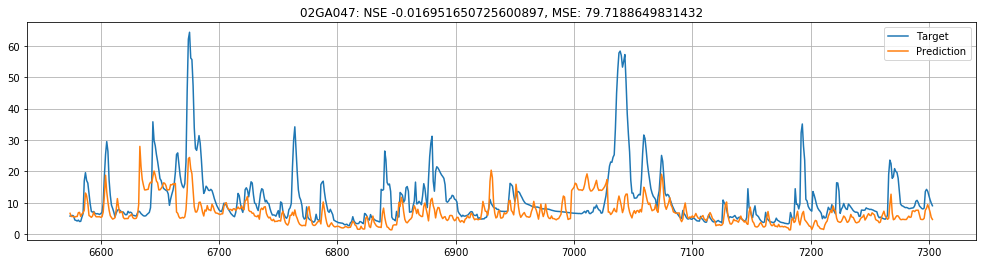

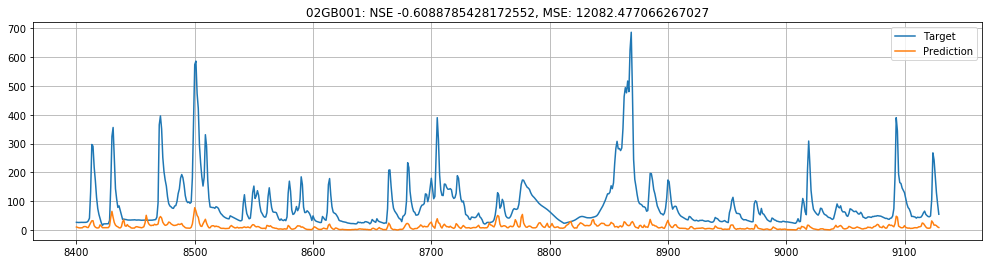

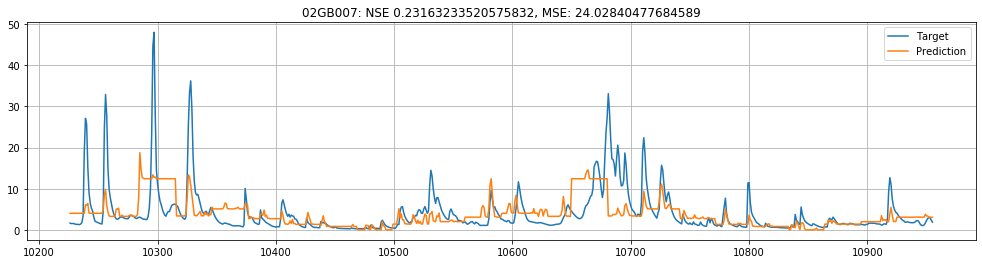

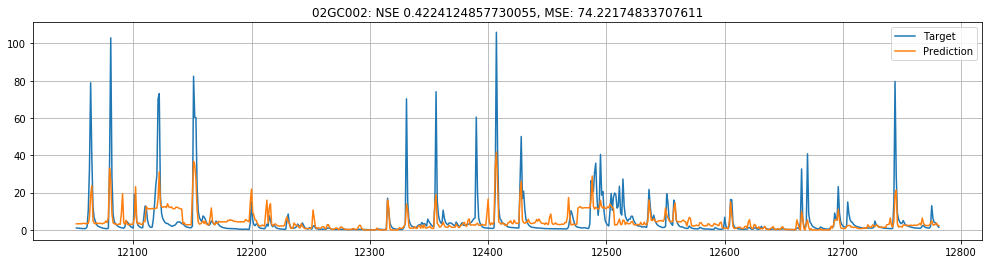

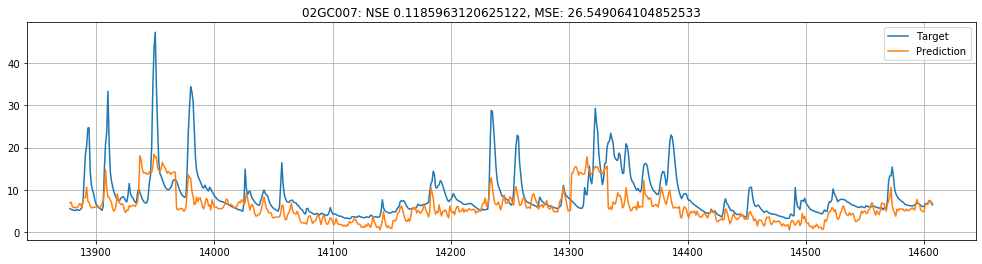

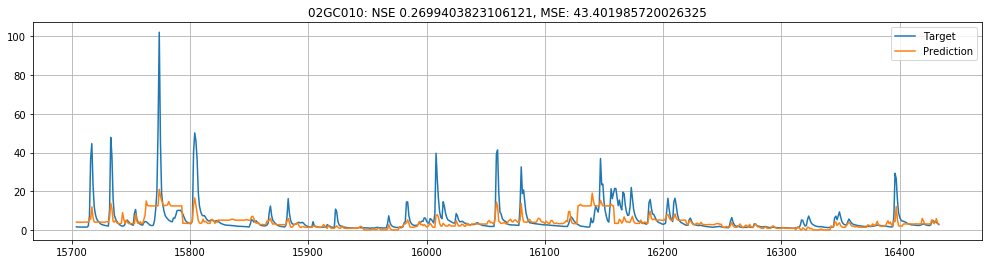

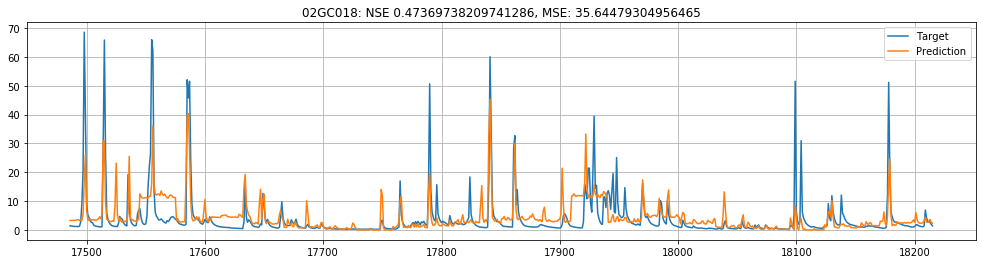

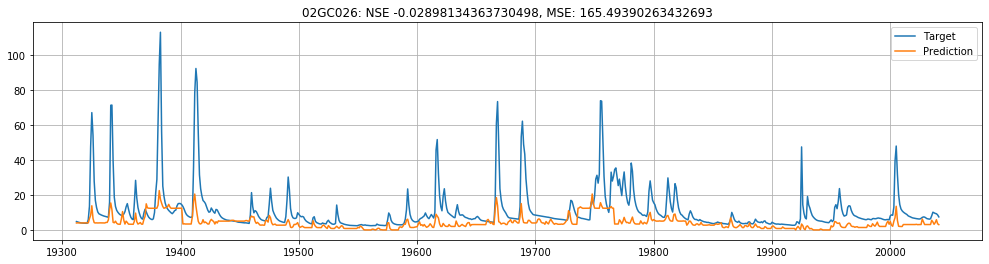

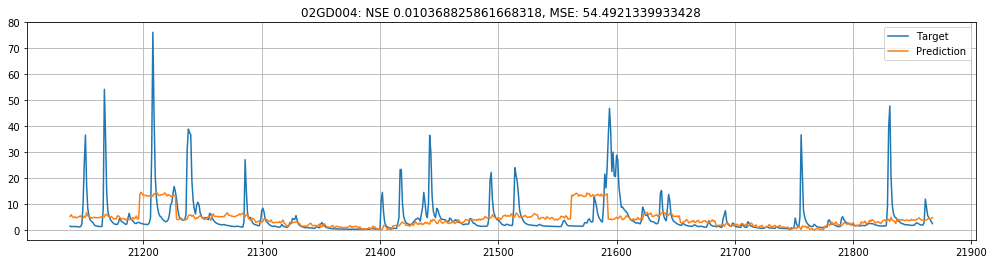

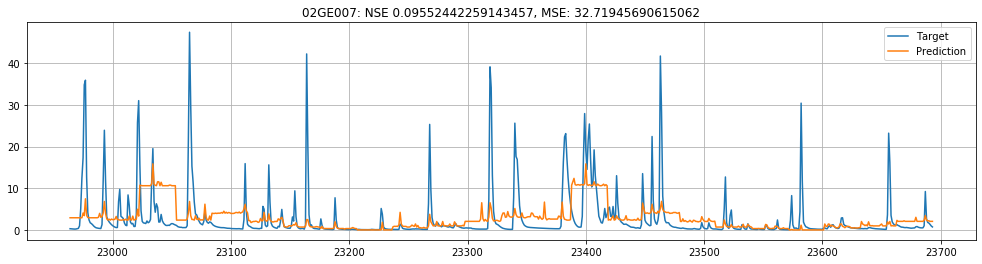

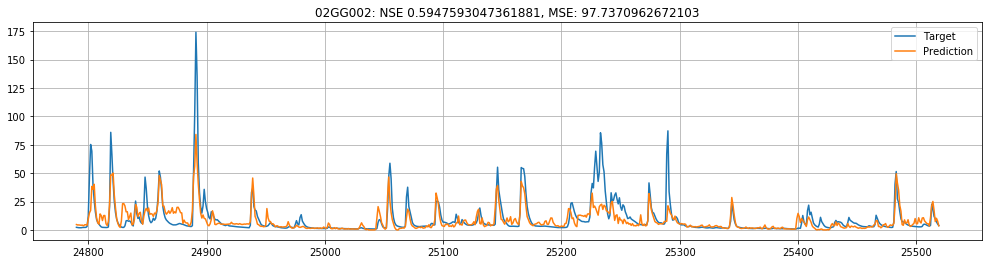

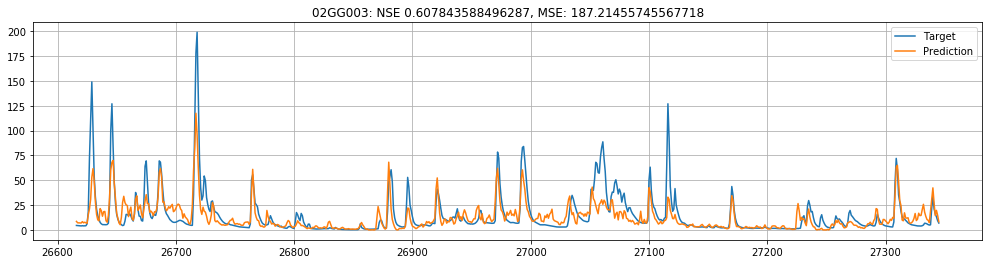

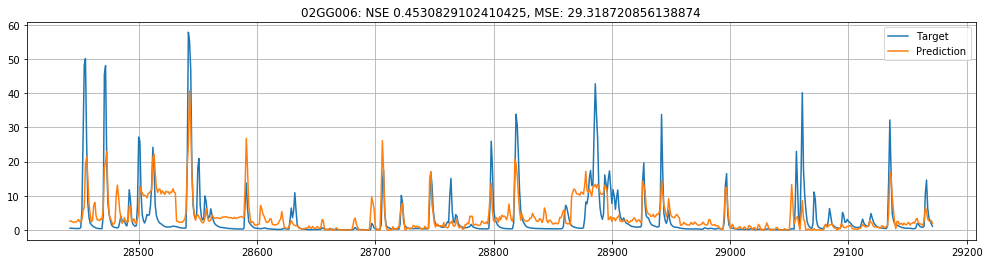

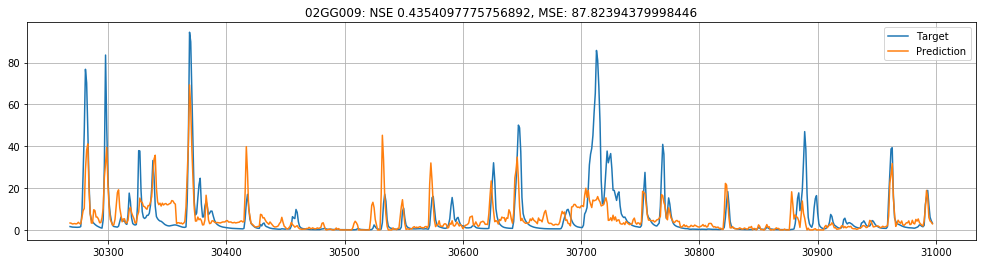

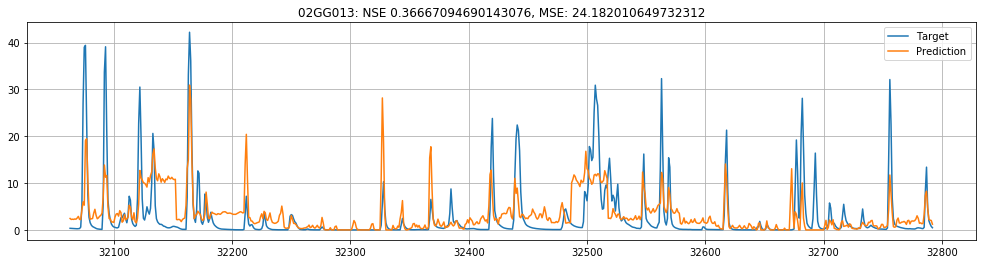

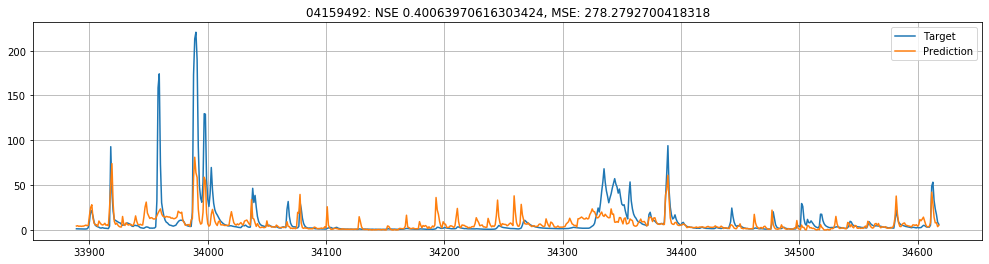

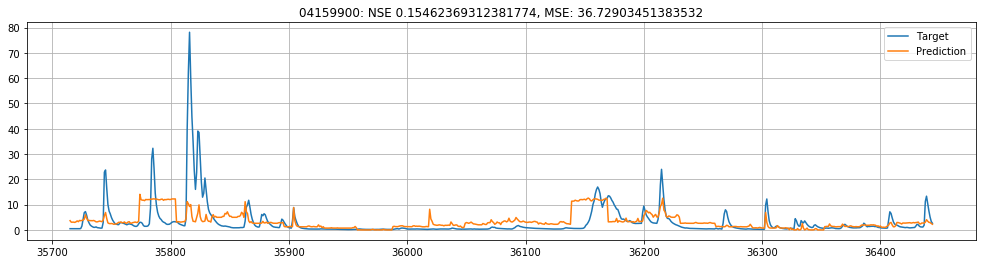

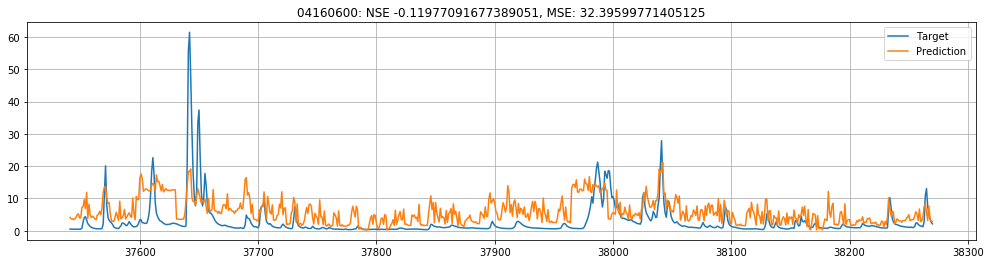

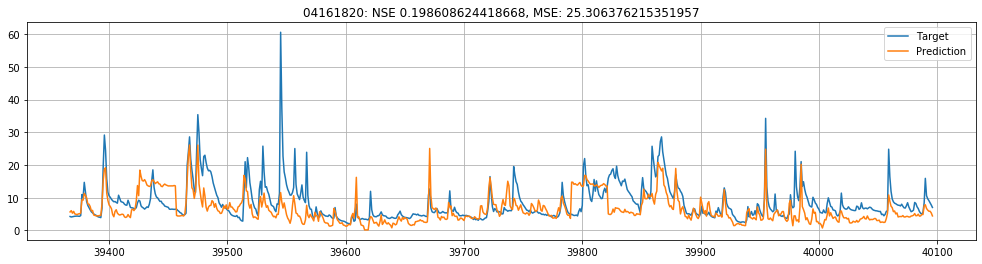

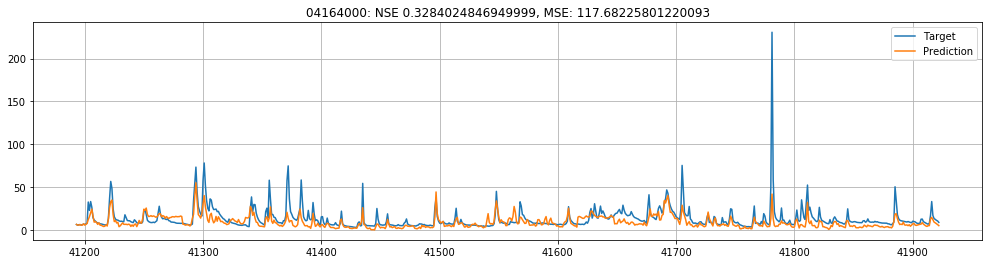

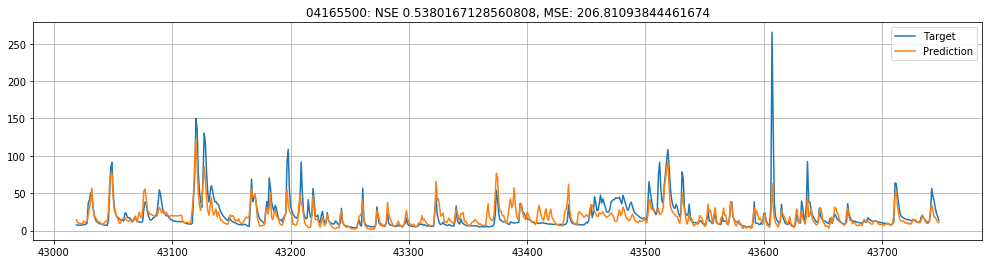

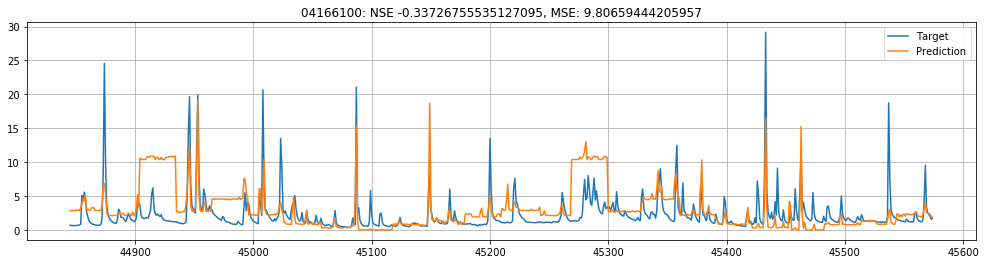

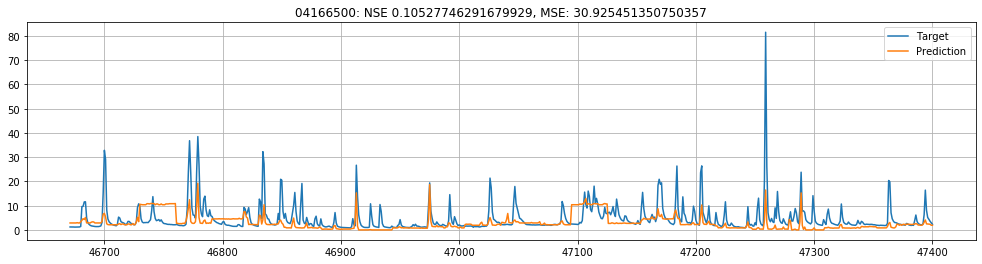

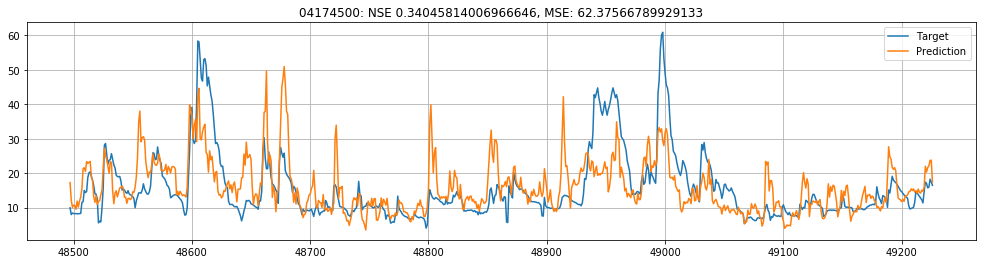

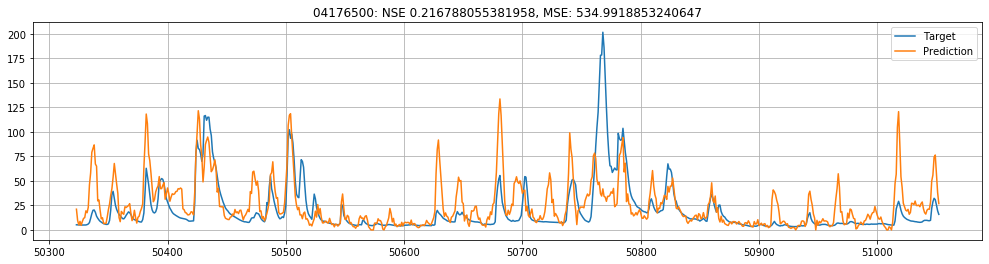

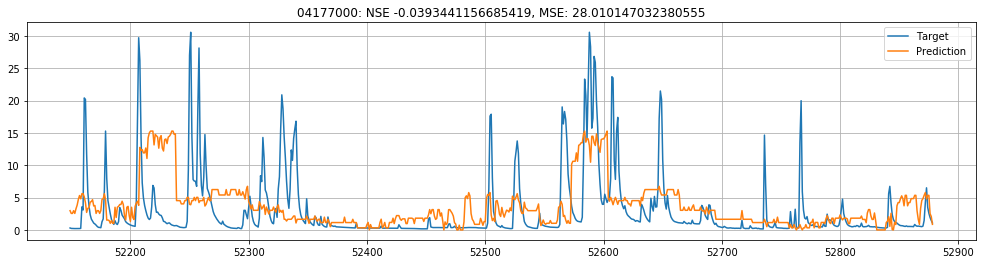

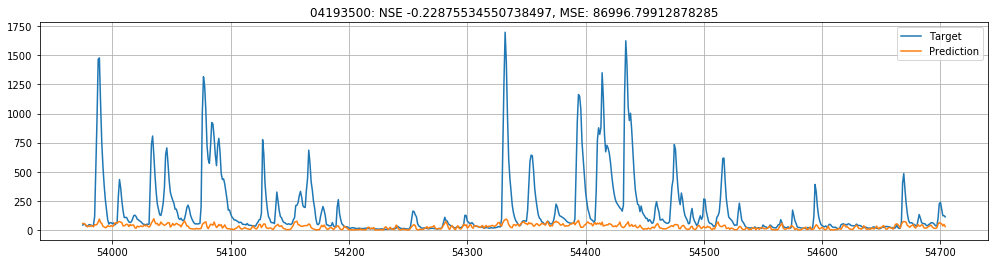

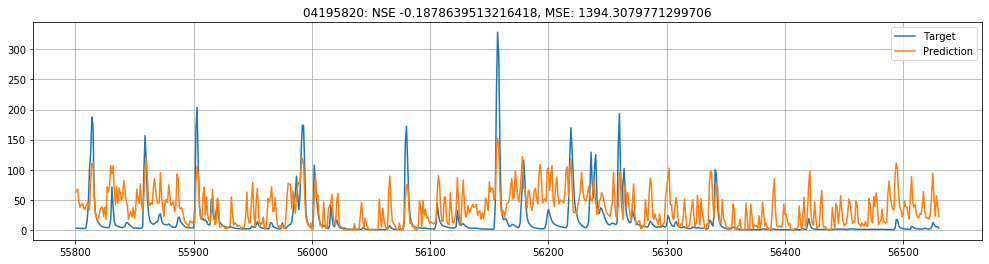

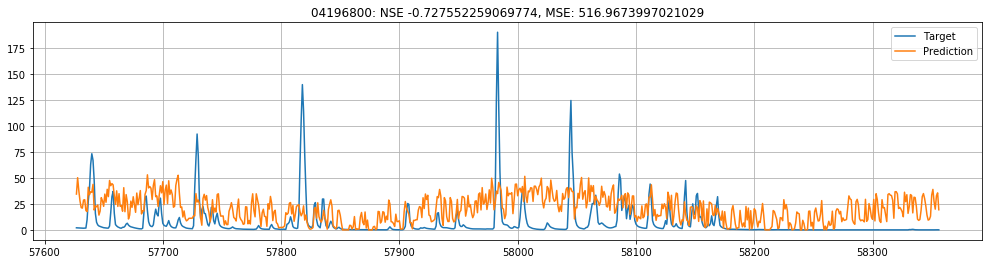

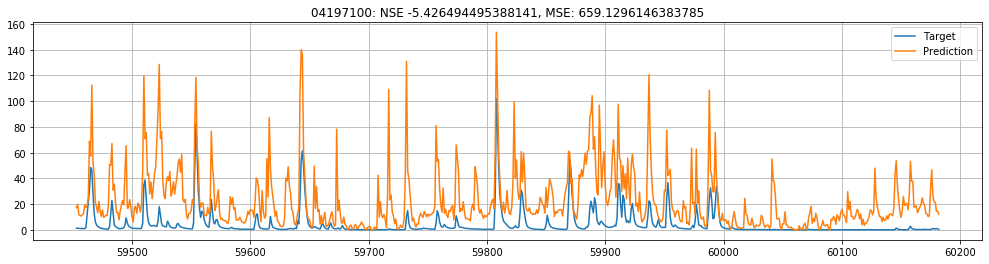

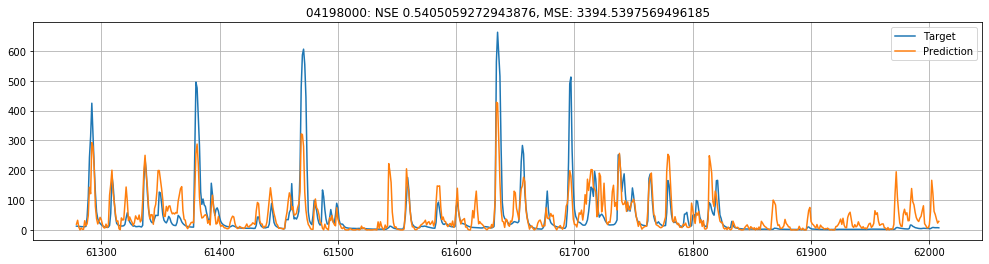

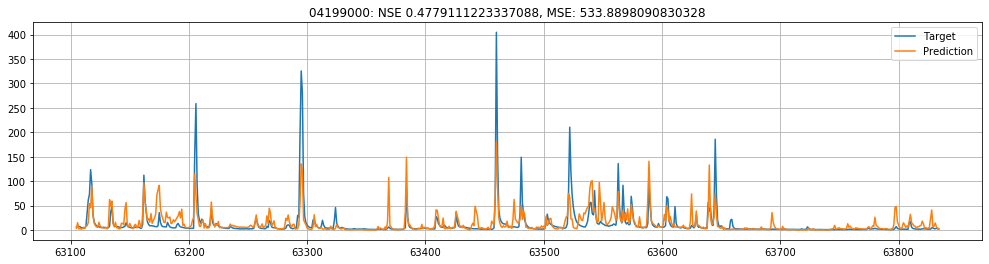

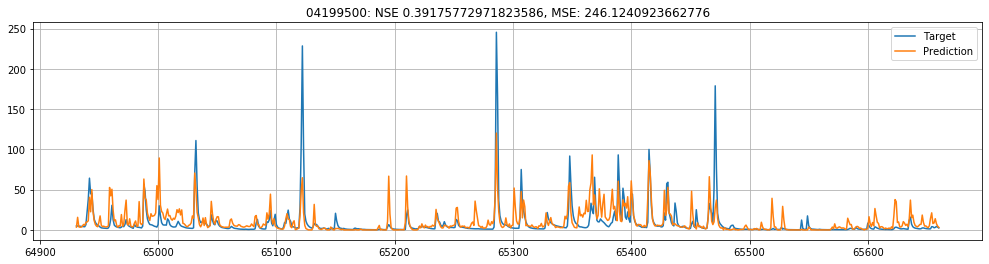

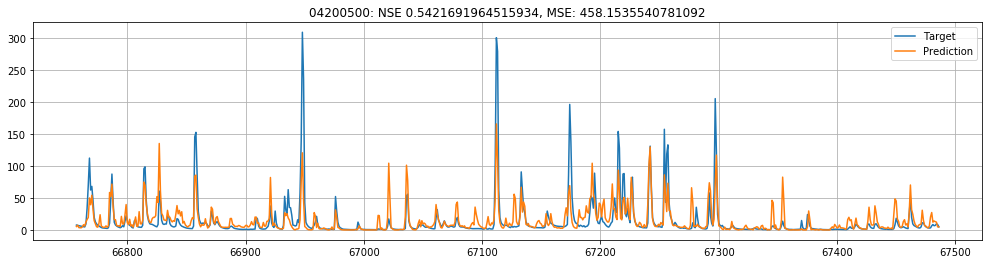

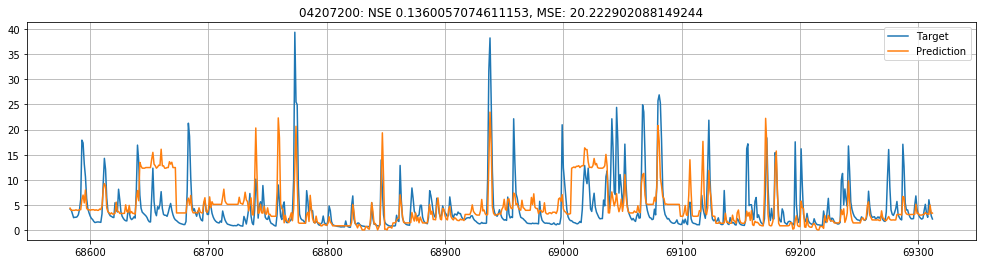

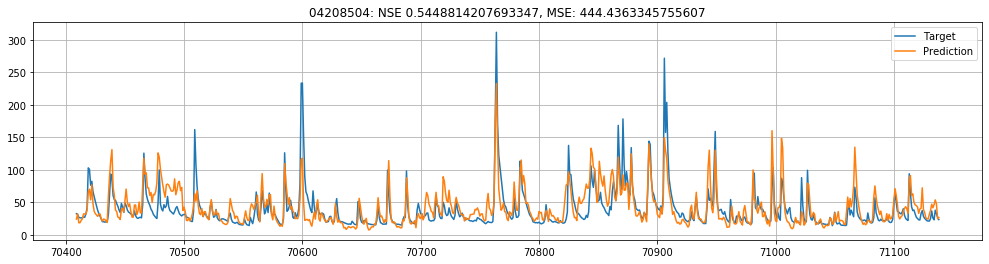

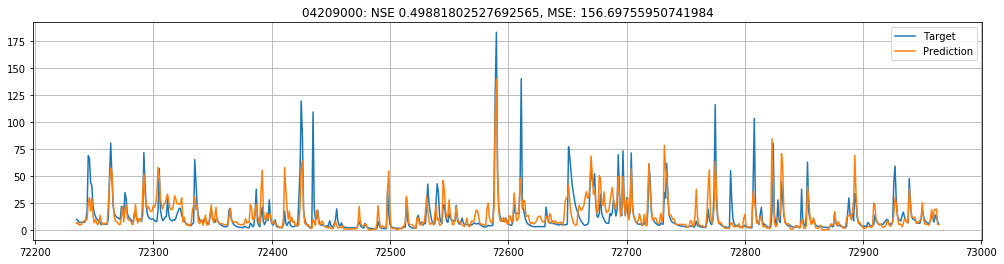

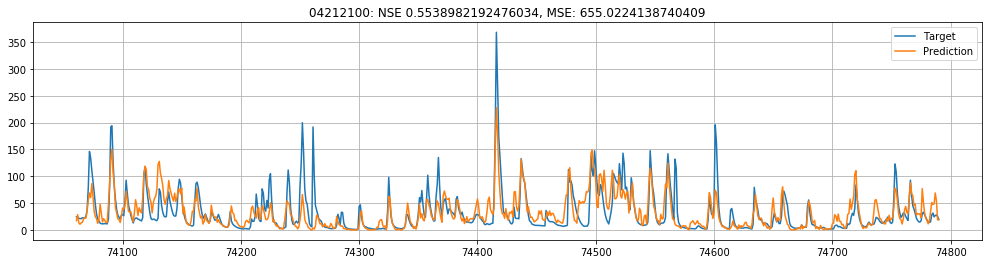

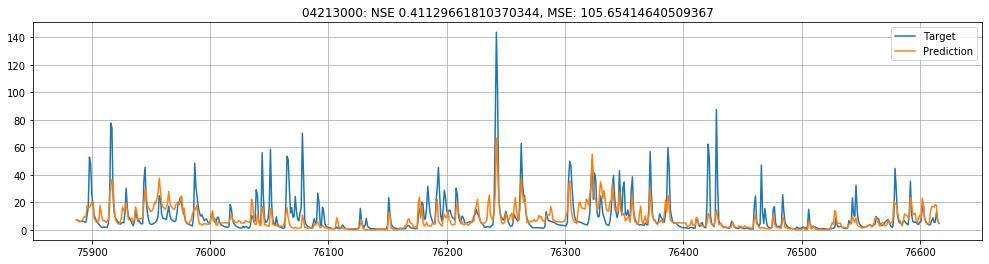

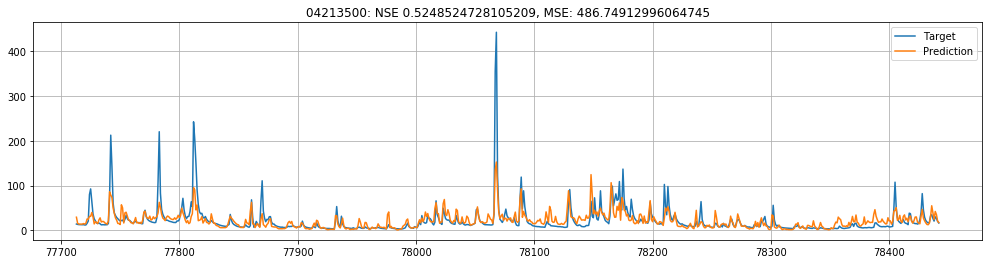

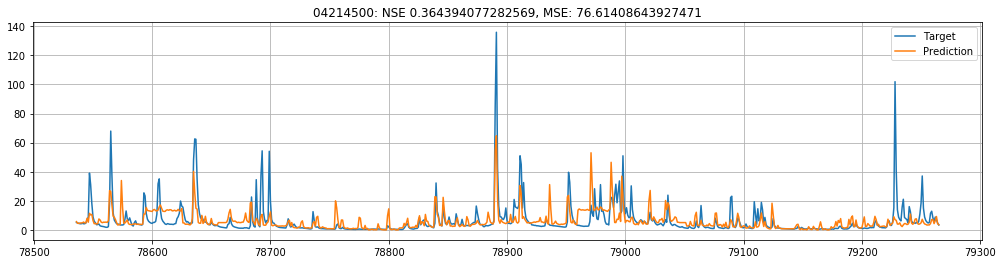

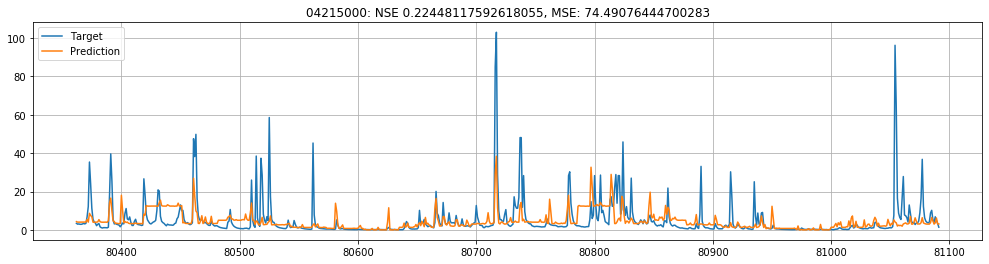

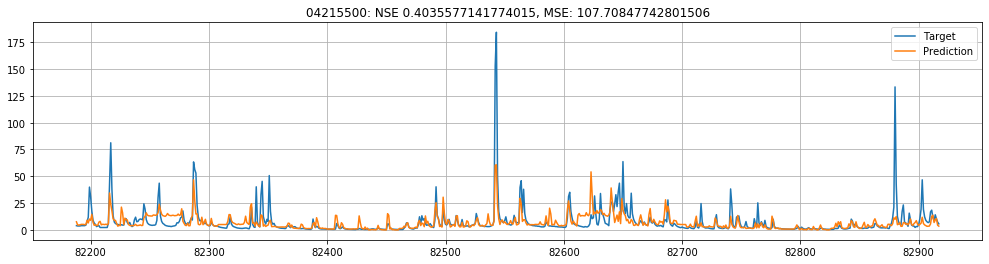

In [8]:
train_nse_list = []
train_mse_list = []
test_nse_list = []
test_mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    if station in test_stations:
        test_nse_list.append(nse)
        test_mse_list.append(mse)
    else:
        train_nse_list.append(nse)
        train_mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Train Median NSE (clipped to 0)', np.median(train_nse_list), '/ Min', np.min(train_nse_list), '/ Max', np.max(train_nse_list))
print('Train Median MSE (clipped to 0)', np.median(train_mse_list), '/ Min', np.min(train_mse_list), '/ Max', np.max(train_mse_list))
print('Test Median NSE (clipped to 0)', np.median(test_nse_list), '/ Min', np.min(test_nse_list), '/ Max', np.max(test_nse_list))
print('Test Median MSE (clipped to 0)', np.median(test_mse_list), '/ Min', np.min(test_mse_list), '/ Max', np.max(test_mse_list))

In [ ]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', predict[['date', 'station', 'runoff', 'actual', 'is_test_station']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

In [ ]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', m, 'all', time_stamp, model_type='sklearn')

In [ ]:
datetime.now().strftime('%Y%m%d-%H%M%S')